In [1]:
import importlib 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import warnings
import numpy as np
import numpy.linalg as la
import scipy as sp
import cupy as cp
import matplotlib.pyplot as plt
from bart import bart
from utils import cfl
from utils import signalprocessing as sig
from utils import models
from utils import iterative

#importlib.reload(models)

# Defining SPARK Helper functions 

In [2]:
def reformattingKspaceForSpark(inputKspace,kspaceOriginal,acsregionX,acsregionY,acsx,acsy,normalizationflag):
    [E,C,_,_] = inputKspace.shape
    kspaceAcsCrop     = kspaceOriginal[:,:,acsregionX[0]:acsregionX[acsx-1]+1,acsregionY[0]:acsregionY[acsy-1]+1] 
    #Ground truth measured ACS data, will be used as the ground truth to compute kspace error we want learn
    kspaceAcsGrappa   = inputKspace[:,:,acsregionX[0]:acsregionX[acsx-1]+1,acsregionY[0]:acsregionY[acsy-1]+1] 
    #GRAPPA reconstructed ACS region.  kspaceAcsCrop - kspaceAcsGrappa = d will be the supervised error we try to learn
    kspaceAcsDifference = kspaceAcsCrop - kspaceAcsGrappa

    #Splitting the difference into the real and imaginary part for the network
    acs_difference_real = np.real(kspaceAcsDifference)
    acs_difference_imag = np.imag(kspaceAcsDifference)

    #print('acs_difference_real shape: ' + str(acs_difference_real.shape))
    #print('acs_difference_imag shape: ' + str(acs_difference_imag.shape))

    #Adding the batch dimension
    kspace_grappa = np.copy(inputKspace)
    kspace_grappa_real  = np.real(kspace_grappa)
    kspace_grappa_imag  = np.imag(kspace_grappa)
    kspace_grappa_split = np.concatenate((kspace_grappa_real, kspace_grappa_imag), axis=1)

    #print('kspace_grappa_split shape: ' + str(kspace_grappa_split.shape))

    #Let's do some normalization
    chan_scale_factors_real = np.zeros((E,C),dtype = 'float')
    chan_scale_factors_imag = np.zeros((E,C),dtype = 'float')

    for e in range(E):
        if(normalizationflag):
            scale_factor_input = 1/np.amax(np.abs(kspace_grappa_split[e,:,:,:]))
            kspace_grappa_split[e,:,:,:] *= scale_factor_input

        for c in range(C):
            if(normalizationflag):
                scale_factor_real = 1/np.amax(np.abs(acs_difference_real[e,c,:,:]))
                scale_factor_imag = 1/np.amax(np.abs(acs_difference_imag[e,c,:,:]))
            else:
                scale_factor_real = 1
                scale_factor_imag = 1

            chan_scale_factors_real[e,c] = scale_factor_real
            chan_scale_factors_imag[e,c] = scale_factor_imag

            acs_difference_real[e,c,:,:] *= scale_factor_real
            acs_difference_imag[e,c,:,:] *= scale_factor_imag

    acs_difference_real = np.expand_dims(acs_difference_real, axis=2)
    acs_difference_real = np.expand_dims(acs_difference_real, axis=2)
    acs_difference_imag = np.expand_dims(acs_difference_imag, axis=2)
    acs_difference_imag = np.expand_dims(acs_difference_imag, axis=2)

    #print('acs_difference_real shape: ' + str(acs_difference_real.shape))
    #print('acs_difference_imag shape: ' + str(acs_difference_imag.shape))

    kspace_grappa_split = torch.from_numpy(kspace_grappa_split)
    kspace_grappa_split = kspace_grappa_split.to(device, dtype=torch.float)
    #print('kspace_grappa_split shape: ' + str(kspace_grappa_split.shape))

    acs_difference_real = torch.from_numpy(acs_difference_real)
    acs_difference_real = acs_difference_real.to(device, dtype=torch.float)
    #print('acs_difference_real shape: ' + str(acs_difference_real.shape))

    acs_difference_imag = torch.from_numpy(acs_difference_imag)
    acs_difference_imag = acs_difference_imag.to(device, dtype=torch.float)
    #print('acs_target_imag shape: ' + str(acs_difference_imag.shape))
    
    return kspace_grappa_split, acs_difference_real, acs_difference_imag, chan_scale_factors_real, chan_scale_factors_imag

In [3]:
def trainingSparkNetwork(kspaceGrappaSplit,acsDifferenceReal,acsDifferenceImag,acsx,acsy,learningRate,iterations):
    '''
    Trains a SPARK networks given some appropriately formatted grappa kspace, acsDifferenceReal, and acsDifferenceImaginary
    Inputs:
        kspaceGrappaSplit: allContrasts x 2 * allChannels x M x N,             Grappa reconstructed kspace which will 
                                                                               be used to learn error
        acsDifferenceReal: allContrasts x allChaannels x 1 x 1 x M x N,        Difference between measured and GRAPPA
                                                                               ACS real portion
        acsDifferenceImag: allContrasts x allChaannels x 1 x 1 M x N,          Difference between measured and GRAPPA
                                                                               ACS imag portion             
        acs:               acss x 1,                                           Indices of ACS region
        learningRate:      scalar,                                             Learaning rate for the networks
        iterations:        scalar,                                             Number of iterations we want to train
    Outputs:
        A network which should reconstruct each contrast and channel        
    '''
    
    [E,C,_,_,_,_] = acsDifferenceReal.shape

    #~~~~~~~~~~~~~~~~~~~~~~~~
    #Training the real models
    #~~~~~~~~~~~~~~~~~~~~~~~~
    real_models      = {}
    real_model_names = []
    
    criterion = nn.MSELoss()
    
    for e in range(0,E):
        for c in range(0,C):
            model_name = 'model' + 'E' + str(e) + 'C' + str(c) + 'r'
            model = models.SPARK_Netv2(coils = C,kernelsize = 3,acsx = acsx, acsy = acsy)
            
            model.to(device)
            
            kspsplit = torch.unsqueeze(kspaceGrappaSplit[e,:,:,:],axis = 0)
            
            #print('Training {}'.format(model_name))
            
            optimizer = optim.Adam(model.parameters(),lr=learningRate)
            running_loss = 0
            
            for epoch in range(iterations):
                optimizer.zero_grad()
                
                _,loss_out = model(kspsplit)
                loss = criterion(loss_out,acsDifferenceReal[e,c,:,:,:,:])
                loss.backward()
                optimizer.step()
                
                running_loss = loss.item()
                #if(epoch == 0):
                    #print('Training started , loss = %.10f' % (running_loss))
            
            real_model_names.append(model_name)
            real_models.update({model_name:model})
            
            #print('Training Complete, loss = %.10f' % (running_loss))
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #Training the imaginary model
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    imag_models      = {}
    imag_model_names = []
    
    criterion = nn.MSELoss()
    
    for e in range(0,E):
        for c in range(0,C):
            model_name = 'model' + 'E' + str(e) + 'C' + str(c) + 'i'            
            model = models.SPARK_Netv2(coils = C,kernelsize = 3,acsx = acsx, acsy = acsy)
            
            model.to(device)
            
            kspsplit = torch.unsqueeze(kspaceGrappaSplit[e,:,:,:],axis = 0)
            
            #print('Training {}'.format(model_name))
            
            optimizer    = optim.Adam(model.parameters(),lr = learningRate)
            running_loss = 0.0
            
            for epoch in range(iterations):
                optimizer.zero_grad()
                
                _,loss_out = model(kspsplit)
                loss = criterion(loss_out,acsDifferenceImag[e,c,:,:,:,:])
                loss.backward()
                optimizer.step()
                
                running_loss = loss.item()
                #if(epoch == 0):
                    #print('Training started , loss = %.10f' % (running_loss))
                
            imag_model_names.append(model_name)
            imag_models.update({model_name : model})

            #print('Training Complete, loss = %.10f' % (running_loss))

    return real_models,real_model_names,imag_models,imag_model_names

In [4]:
def applySparkCorrection(kspaceToCorrect,kspaceGrappaSplit,real_model,imag_model,chanScaleFactorReal,chanScaleFactorImag):
    '''
    Given a set of models trained for a particular contrast, apply SPARK to all of the contrasts
    Inputs:
        kspaceToCorrect   - M x N,       Kspace that we want to correct
        kspaceGrappasplit - allcoils x M x N  Kspace that will be used to reconstuct the particular for this kspace
        real_model      - model          Model for correcting the real component
        imag_model      - model          Model for correcting the imaginary component
        chanScaleFactor - Scalar         Scaling parameter for the particular piece of kspace which is corrected
    outputs:
        kspaceCorrected - M x N       Corrected kspace
        
    '''
    
    correctionr = real_model(torch.unsqueeze(kspaceGrappaSplit,axis=0))[0].cpu().detach().numpy()
    correctioni = imag_model(torch.unsqueeze(kspaceGrappaSplit,axis=0))[0].cpu().detach().numpy()
    corrected = correctionr[0,0,:,:]/chanScaleFactorReal + 1j * correctioni[0,0,:,:] / chanScaleFactorImag + kspaceToCorrect
    
    return corrected

In [5]:
kspace    = np.expand_dims(np.transpose(sp.io.loadmat('grappa_recons/kspace_full.mat')['kspace'],axes = (2,0,1)),axis = 0)

[E,C,M,N] = kspace.shape

#-Normlizing for all experiments
normalizationflag = 1
normalizeAll      = 0

#-Readout parameters stay the same (1D acceleration in second dimension)
Rx   = 1
acsx = M

all_accelerations  = [5,6]                    #Second dimension accelerations to loop over
all_acs_sizes      = [20,24,30,36,40]          #Second dimension acs_sizes to loop over
all_iterations     = [200]       #Number of iterations for each reconstruction
all_learning_rates = [.01]    #Different learning rates to loop over

# Preparing and running the parameter loop

In [6]:
A = len(all_accelerations)
S = len(all_acs_sizes)
I = len(all_iterations)
R = len(all_learning_rates)

all_kspaces_spark = np.zeros((I,R,A,S,E,C,M,N),dtype = complex)
all_kspaces_grappa = np.zeros((I,R,A,S,E,C,M,N),dtype = complex)

ctr = 1
for aa in range(A):
    for ss in range(S):
        for ii in range(I):
            for rr in range(R):
                Ry   = all_accelerations[aa]
                acsy = all_acs_sizes[ss]
                iterations   = all_iterations[ii]
                learningRate = all_learning_rates[rr]
                
                print('Recon %d/%d || R %d || acsy %d || s %.5f || it %d' % \
                     (ctr,A*S*I*R,Ry,acsy,learningRate,iterations))
                ctr += 1
                
                kspaceGrappa = np.expand_dims(np.transpose(sp.io.loadmat(\
                    'grappa_recons/kspace_grappa_Rx1Ry%dacsx%dacsy%d.mat' %\
                    (Ry,acsx,acsy))['kspace_grappa'],axes = (2,0,1)),axis = 0)
                
                ### Generate the ACS region ###            
                acsregionX = np.arange(M//2 - acsx // 2,M//2 + acsx//2) 
                acsregionY = np.arange(N//2 - acsy // 2,N//2 + acsy//2) 

                kspaceAcsZerofilled = np.zeros((E,C,M,N),dtype = complex)
                kspaceAcsZerofilled[:,:,acsregionX[0]:acsregionX[acsx-1]+1,acsregionY[0]:acsregionY[acsy-1]+1] = kspace[:,:,acsregionX[0]:acsregionX[acsx-1]+1,acsregionY[0]:acsregionY[acsy-1]+1]
                
                ### Training the Network ###
                device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

                [kspace_grappa_split, acs_difference_real, acs_difference_imag,chan_scale_factors_real,chan_scale_factors_imag] = \
                    reformattingKspaceForSpark(kspaceGrappa,kspaceAcsZerofilled,acsregionX,acsregionY,acsx,acsy,normalizationflag)

                realSparkGrappaModels,realSparkGrappaNames,imagSparkGrappaModels,imagSparkGrappaNames = \
                    trainingSparkNetwork(kspace_grappa_split,acs_difference_real,acs_difference_imag,acsregionX,acsregionY,learningRate,iterations)
                
                ### Applying the SPARK correction with acs replacement###
                kspaceCorrected    = np.zeros((E,C,M,N),dtype = complex)


                for reconContrast in range(0,E):
                    for c in range(0,C):
                        #Perform reconstruction coil by coil
                        model_namer = 'model' + 'E' + str(reconContrast) + 'C' + str(c) + 'r'
                        model_namei = 'model' + 'E' + str(reconContrast) + 'C' + str(c) + 'i'

                        real_model = realSparkGrappaModels[model_namer]
                        imag_model = imagSparkGrappaModels[model_namei]

                        kspaceToCorrect   = kspaceGrappa[reconContrast,c,:,:]
                        kspaceGrappaSplit = kspace_grappa_split[reconContrast,:,:,:]

                        currentCorrected = \
                                applySparkCorrection(kspaceToCorrect,kspaceGrappaSplit,real_model,imag_model,\
                                    chan_scale_factors_real[reconContrast,c], chan_scale_factors_imag[reconContrast,c])

                        kspaceCorrected[reconContrast,c,:,:] = currentCorrected  
                        
                kspaceCorrectedReplaced    = np.copy(kspaceCorrected)
                kspaceCorrectedReplaced[:,:,acsregionX[0]:acsregionX[acsx-1],acsregionY[0]:acsregionY[acsy-1]] = \
                    kspace[:,:,acsregionX[0]:acsregionX[acsx-1],acsregionY[0]:acsregionY[acsy-1]] 
                
                kspaceGrappaReplaced    = np.copy(kspaceGrappa)
                kspaceGrappaReplaced[:,:,acsregionX[0]:acsregionX[acsx-1],acsregionY[0]:acsregionY[acsy-1]] = \
                    kspace[:,:,acsregionX[0]:acsregionX[acsx-1],acsregionY[0]:acsregionY[acsy-1]] 
                
                ### Save current values ###
                all_kspaces_spark[ii,rr,aa,ss,:,:,:,:]  = kspaceCorrectedReplaced
                all_kspaces_grappa[ii,rr,aa,ss,:,:,:,:] = kspaceGrappaReplaced

Recon 1/10 || R 5 || acsy 20 || s 0.01000 || it 200
Recon 2/10 || R 5 || acsy 24 || s 0.01000 || it 200
Recon 3/10 || R 5 || acsy 30 || s 0.01000 || it 200
Recon 4/10 || R 5 || acsy 36 || s 0.01000 || it 200
Recon 5/10 || R 5 || acsy 40 || s 0.01000 || it 200
Recon 6/10 || R 6 || acsy 20 || s 0.01000 || it 200
Recon 7/10 || R 6 || acsy 24 || s 0.01000 || it 200
Recon 8/10 || R 6 || acsy 30 || s 0.01000 || it 200
Recon 9/10 || R 6 || acsy 36 || s 0.01000 || it 200
Recon 10/10 || R 6 || acsy 40 || s 0.01000 || it 200


# Computing RMSE for each reconstruction and extracting best iteration/learning rate pair for each acs_size/R pair 

In [7]:
truth       = sig.rsos(sig.ifft2c(kspace),-3)
all_grappa  = sig.rsos(sig.ifft2c(all_kspaces_grappa),-3)
all_spark   = sig.rsos(sig.ifft2c(all_kspaces_spark),-3)

### Computing all rmses

In [8]:
all_rmse_grappa = np.zeros((I,R,A,S))
all_rmse_spark  = np.zeros((I,R,A,S))

for aa in range(A):
    for ss in range(S):
        for ii in range(I):
            for rr in range(R):
                all_rmse_grappa[ii,rr,aa,ss] = sig.rmse(sig.nor(truth),sig.nor(all_grappa[ii,rr,aa,ss,:,:,:]))
                all_rmse_spark[ii,rr,aa,ss]  = sig.rmse(sig.nor(truth),sig.nor(all_spark[ii,rr,aa,ss,:,:,:]))

In [9]:
all_rmse_grappa_final = all_rmse_grappa[0,0,:,:]
all_grappa_final      = all_grappa[0,0,:,:,:,:,:]

### Compute minimum rmse along iteration and learning dimensions  

In [10]:
### Find minimum along iteration dimension ###
all_rmse_spark_tmp  = np.zeros((R,A,S))
best_it_spark_index  = np.zeros((R,A,S),dtype = 'int')

for aa in range(A):
    for ss in range(S):
        for rr in range(R):
            cur_rmse_spark  = 1e16
            for ii in range(I): 
                if(all_rmse_spark[ii,rr,aa,ss] < cur_rmse_spark):
                    best_it_spark_index[rr,aa,ss] = ii
                    cur_rmse_spark = all_rmse_spark[ii,rr,aa,ss]
            
            all_rmse_spark_tmp[rr,aa,ss] = all_rmse_spark[best_it_spark_index[rr,aa,ss],rr,aa,ss]
            
### Find minimum along learning rate dimension ###
all_rmse_spark_final = np.zeros((A,S))
best_lr_spark_index  = np.zeros((A,S),dtype = 'int')

for aa in range(A):
    for ss in range(S):
        cur_rmse_spark  = 1e16
        for rr in range(R): 
            if(all_rmse_spark_tmp[rr,aa,ss] < cur_rmse_spark):
                best_lr_spark_index[aa,ss] = rr
                cur_rmse_spark = all_rmse_spark_tmp[rr,aa,ss]

        all_rmse_spark_final[aa,ss] = all_rmse_spark_tmp[best_lr_spark_index[aa,ss],aa,ss]
        


### Loop through and print results 

In [11]:
for aa in range(A):
    print("Acceleration %d" % (all_accelerations[aa]))
    for ss in range(S):
        print("  Acs Size %d" % (all_acs_sizes[ss]))
        print("    grappa rmse: %.2f" % (all_rmse_grappa_final[aa,ss]*100))
        print("    spark rmse:  %.2f" % (all_rmse_spark_final[aa,ss]*100))
        print("         iterations: %d" % (all_iterations[best_it_spark_index[best_lr_spark_index[aa,ss],aa,ss]]))
        print("         stepsize:   %.5f" % (all_learning_rates[best_lr_spark_index[aa,ss]]))

Acceleration 5
  Acs Size 20
    grappa rmse: 6.98
    spark rmse:  6.11
         iterations: 200
         stepsize:   0.01000
  Acs Size 24
    grappa rmse: 6.82
    spark rmse:  5.72
         iterations: 200
         stepsize:   0.01000
  Acs Size 30
    grappa rmse: 6.67
    spark rmse:  5.36
         iterations: 200
         stepsize:   0.01000
  Acs Size 36
    grappa rmse: 6.49
    spark rmse:  5.23
         iterations: 200
         stepsize:   0.01000
  Acs Size 40
    grappa rmse: 6.37
    spark rmse:  5.04
         iterations: 200
         stepsize:   0.01000
Acceleration 6
  Acs Size 20
    grappa rmse: 12.48
    spark rmse:  8.51
         iterations: 200
         stepsize:   0.01000
  Acs Size 24
    grappa rmse: 12.45
    spark rmse:  7.55
         iterations: 200
         stepsize:   0.01000
  Acs Size 30
    grappa rmse: 11.83
    spark rmse:  7.15
         iterations: 200
         stepsize:   0.01000
  Acs Size 36
    grappa rmse: 11.46
    spark rmse:  6.33
         ite

# Visualize desired acceleration 

In [12]:
#-Get best spark image for each acs size/acceleration
all_spark_final = np.zeros((A,S,E,M,N),dtype = complex)

for aa in range(A):
    for ss in range(S):
        all_spark_final[aa,ss,:,:,:] = all_spark[best_it_spark_index[best_lr_spark_index[aa,ss],aa,ss],\
                                                best_lr_spark_index[aa,ss],aa,ss]

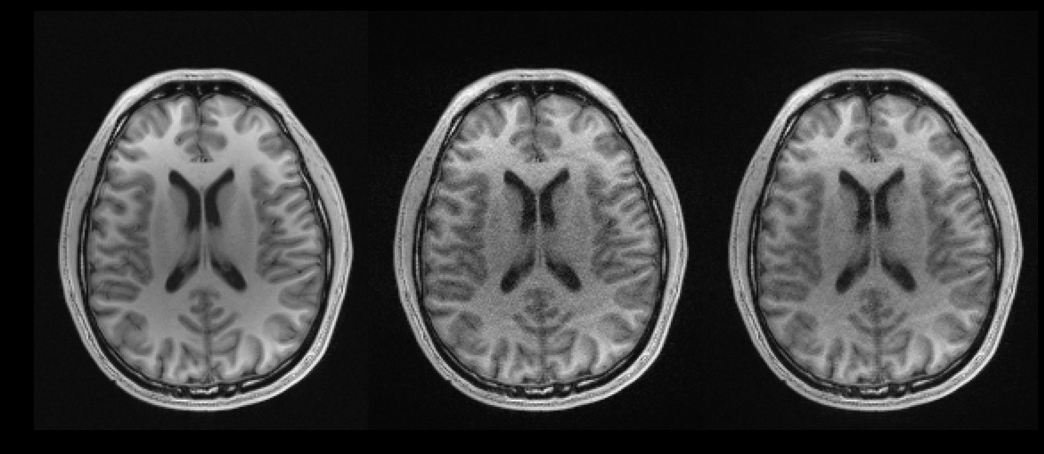

In [15]:
aa = 0 #accel to show
ss = 0 #acs-size to show

display = np.transpose(sig.nor(np.concatenate((truth,all_grappa_final[aa,ss,:,:,:],all_spark_final[aa,ss,:,:,:]),axis = 0)),(0,2,1))
sig.mosaic(display,1,3)

# Saving GRAPPA/SPARK recons for each acs/acceleration + all RMSE's

In [16]:
results = {'truth':   np.squeeze(truth),
           'all_grappa' :   np.squeeze(all_grappa_final),
           'all_spark': np.squeeze(all_spark_final),
           'all_grappa_rmse' : np.squeeze(all_rmse_grappa_final),
           'all_spark_rmse': np.squeeze(all_rmse_spark_final),
           'accelerations': all_accelerations,
           'acs_sizes': all_acs_sizes}

sp.io.savemat('results/spark_ablation.mat', results, oned_as='row')